In [780]:

# Text preprocessing
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string
from typing import Union


# Model/Train Helpers
import random
import time
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker



# PyTorch
import torch
import torch.nn as nn

# Character-Level RNN for Classifying Name Origins
This notebook is inspired by [this pytorch tutorial](https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html). The objective is to use a simple, vanilla RNN to process human names at the character level and predict the name's country of origin.  

It is a good tutorial, but it doesn't implement an RNN at a deep enough level to satisfy my desires. So I first implement a basic RNN at the tensor level (still using PyTorch), so that all the matrix multiplication is done from scratch. This provides insights into the unique nature of processing data sequentially.  

Then I follow the tutorial to implement a vanilla RNN in torch at a slightly higher level, using the torch.nn modules to implement each layer.  



## Collecting Data

In [3]:
def findFiles(path): return glob.glob(path)
print(findFiles('./data/rnn_tut_data/names/*.txt'))

['./data/rnn_tut_data/names\\Arabic.txt', './data/rnn_tut_data/names\\Chinese.txt', './data/rnn_tut_data/names\\Czech.txt', './data/rnn_tut_data/names\\Dutch.txt', './data/rnn_tut_data/names\\English.txt', './data/rnn_tut_data/names\\French.txt', './data/rnn_tut_data/names\\German.txt', './data/rnn_tut_data/names\\Greek.txt', './data/rnn_tut_data/names\\Irish.txt', './data/rnn_tut_data/names\\Italian.txt', './data/rnn_tut_data/names\\Japanese.txt', './data/rnn_tut_data/names\\Korean.txt', './data/rnn_tut_data/names\\Polish.txt', './data/rnn_tut_data/names\\Portuguese.txt', './data/rnn_tut_data/names\\Russian.txt', './data/rnn_tut_data/names\\Scottish.txt', './data/rnn_tut_data/names\\Spanish.txt', './data/rnn_tut_data/names\\Vietnamese.txt']


In [4]:
# All letters in the vocabulary
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)
print(all_letters)
print(f"{n_letters = }")

abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'
n_letters = 57


In [5]:
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )    

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]


# example
unicodeToAscii('Ślusàrski')

'Slusarski'

In [754]:
# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []
for filename in findFiles('data/rnn_tut_data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)
print(f"{n_categories = }")

n_categories = 18


In [758]:
for cat in all_categories:
    print(f"{cat} - Names = {len(category_lines[cat])}")

Arabic - Names = 2000
Chinese - Names = 268
Czech - Names = 519
Dutch - Names = 297
English - Names = 3668
French - Names = 277
German - Names = 724
Greek - Names = 203
Irish - Names = 232
Italian - Names = 709
Japanese - Names = 991
Korean - Names = 94
Polish - Names = 139
Portuguese - Names = 74
Russian - Names = 9408
Scottish - Names = 100
Spanish - Names = 298
Vietnamese - Names = 73


### Data -> Tensors

In [7]:
def letterToIndex(letter):
    return all_letters.find(letter)

def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1 ##index the letter in the onehot-encoding
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print( letterToTensor("J") )
print( (lineToTensor("Hello")).shape )


tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


### Helper Functions
`categoryFromOutput()` decodes the model's output into category labels.  
`randomTrainingExample()` provides one random training ex

In [8]:
def categoryFromOutput(output):
    """Decode model output into category prediction"""
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

In [719]:
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample(category : str = None):
    """Randomly pick training examples. Optionally provide specific nationality category."""
    if category is None: ##pick random category
        category = all_categories[random.randint(0, len(all_categories) - 1)]

    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor


# Example
for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)


category = Chinese / line = Huan
category = German / line = Kerwer
category = Irish / line = Maguire
category = Arabic / line = Totah
category = Portuguese / line = Freitas
category = Spanish / line = Melendez
category = Vietnamese / line = Giang
category = English / line = Bingham
category = Czech / line = Kerner
category = English / line = Upsdell


# Basic RNN Diagram



In [555]:
"""
A BASIC RNN
- Note that inputs are sequential so this is not an 'unrolled' RNN diagram. 
- Imagine each input of length n consists of sub-inputs [t0,...,tn-1, tn] and each hidden state consists of sub-states [h0...,hn-1, hn]
- t0 and h0 (a zero vector) are passed in and concatenated, then used to update the OUTPUT and the hidden state 


[input]          [hidden]<---
    |_____      _____|      |
          |    |            |
        [combined]          |       (Concatenate the input and hidden layers)
    _____|       |__        |
   |                |       |
  [i2o]            [i2h]    |      (NN 'hidden layers' - inputs to outputs, inputs to hidden)
   |                |       |       (could apply an activation function)
[softmax]           |       |
   |                ⬇       |       
   ⬇             [hidden]--->
[OUTPUT]



_____________________________________
For the tensor level implementation, the [combined] layer corresponds to 
`h = torch.tanh( (self.W_xh @ x.T) + (self.W_hh @ hidden) + self.bh)`
where W_xh (weight matrix) maps [input] to [combined] and W_hh maps [hidden] to [combined], and there is a bias term as well.  
This step both combines the inputs with the current hidden state AND produces the new hidden state, h, essentially acting as [i2h] as well.  
The [i2o] layer uses h, the new hidden state which is determined by the previous hidden state and the current inputs, 
to produce the output. The [i2o] layer is essentially represented by the W_hy matrix which maps from h to [OUTPUT].

"""

"\nA BASIC RNN\n- Note that inputs are sequential so this is not an 'unrolled' RNN diagram. \n- Imagine each input of length n consists of sub-inputs [t0,...,tn-1, tn] and each hidden state consists of sub-states [h0...,hn-1, hn]\n- t0 and h0 (a zero vector) are passed in and concatenated, then used to update the OUTPUT and the hidden state \n\n\n[input]          [hidden]<---\n    |_____      _____|      |\n          |    |            |\n        [combined]          |       (Concatenate the input and hidden layers)\n    _____|       |__        |\n   |                |       |\n  [i2o]            [i2h]    |      (NN 'hidden layers' - inputs to outputs, inputs to hidden)\n   |                |       |       (could apply an activation function)\n[softmax]           |       |\n   |                ⬇       |       \n   ⬇             [hidden]--->\n[OUTPUT]\n\n\n\n_____________________________________\nFor the tensor level implementation, the [combined] layer corresponds to \n`h = torch.tanh( (

# TENSOR LEVEL IMPLEMENTATION
Inspired by ["The Unreasonable Effectiveness of Recurrent Neural Networks"](https://karpathy.github.io/2015/05/21/rnn-effectiveness/).  

Some notes of interest:
- The weights in my hidden state were exploding until I multiplied a small coefficient by the randomly initialized weight matrices. While I still used a basic random uniform generator, this shows how important initialization is. 
- When the hidden state explodes, the activation fn (whether relu or tanh) causes the new hidden state to be unuseful for training (with tanh I found that it would always revert to all 1s since the weights got very large and positive and with relu I found that it would always rever to all 0s since the weights got very large and negative).  This made it impossible for the model to learn.   

In [585]:
class BasicRNN:
    def __init__(self, input_size, hidden_size, output_size):
        """Initialize a basic RNN model."""
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

    def random_weights(self):
        """Randomly initialize model weights"""
        # Weight matrix that maps hidden to hidden
        self.W_hh = torch.rand((self.hidden_size, self.hidden_size)) * 0.01
        # Weight matrix that maps inputs to hidden
        self.W_xh = torch.rand((self.hidden_size, self.input_size)) * 0.01
        # Weight matrix that maps updated hidden/input concatenation to output 
        self.W_hy = torch.rand((self.output_size, self.hidden_size)) * 0.01
        # Biases
        self.bh = torch.zeros((self.hidden_size, 1)) # hidden bias
        self.by = torch.zeros((self.output_size, 1)) # output bias
        for p in [self.W_hh, self.W_xh, self.W_hy, self.bh, self.by]:
            p.requires_grad = True
    
    def init_hidden(self):
        """Initialize the hidden state with the zero vector."""
        return torch.zeros((self.hidden_size, 1), requires_grad=True)

    def forward(self, hidden, x, y=None):
        """Perform one forward step."""
        # update hidden state
        h = torch.relu( (self.W_xh @ x.T) + (self.W_hh @ hidden) + self.bh)
        # compute output vector
        logits = (self.W_hy @ h) + self.by
        probs = torch.nn.functional.softmax(logits, dim=0)

        # LOSS
        loss = None
        if y is not None:
            y_ohe = torch.zeros(self.output_size)
            y_ohe[y] = 1.0
            loss = torch.nn.functional.cross_entropy(logits.squeeze(), y_ohe)
        self.loss = loss

        return h, probs, loss
    
    def backprop_update(self, lr=0.1):
        """Backprop to calculate gradients. Apply gradients with vanills SGD."""
        params = [self.W_hh, self.W_xh, self.W_hy, self.bh, self.by]

        # ensure gradients are zerod
        for p in params:
            p.grad = None

        # backprop
        self.loss.backward()

        # update
        for i, p in enumerate(params):
            #if p.grad is not None:
            if p.grad is None:
                print(i)
            p.data += -lr * p.grad
    
    def predict(self, name : str):
        """Predict the country of origin for a new name. Relies on external helper fns."""
        
        sample = lineToTensor(name)
        with torch.no_grad():
            hidden = self.init_hidden()
            for t in range(sample.shape[0]):
                hidden, probs, _ = self.forward(hidden=hidden, x=sample[t], y=None)
        
        pred = torch.argmax(probs)
        pred_cat = all_categories[pred]

        return pred_cat

In [564]:
# Generate some training data (just use 1000 samples for quicker training)
xs, ys, names = [],[],[]
samples = 1000

for _ in range(samples):
    cat, line, y, x = randomTrainingExample()
    xs.append(x)
    ys.append(y)
    names.append(line)
print(names[:10])

['Park ', 'Gaspar', 'Abboud', 'Tourna', 'Zogby', 'Ankeren', 'Missiakos', 'Tahan', 'Abbascia', 'Croce']


In [586]:
# Initialize the model and initialize weights randomly
model = BasicRNN(input_size=n_letters, hidden_size=64, output_size=n_categories)
model.random_weights()

losses = []
preds = []
# hiddens = []

In [610]:
# TRAINING
# For each epoch, iterate over all of the samples
# For each sample, pass in one character after the other to update the hidden state, and then backprop after the sample is done
epochs = 10
for ep in range(epochs):
    for s in range(samples):
        x_s = xs[s]
        y_s = ys[s]
        
        # Initialize hidden state with zero vector
        hidden = model.init_hidden()
        # For the current sample, pass in each character sequentially to update hidden state
        for t in range(x_s.shape[0]):
            hidden, probs, loss = model.forward(hidden, x_s[t], y_s)
        # Backprop
        model.backprop_update(lr=0.01)
        
        # if last epoch, save final predicted probs for each sample
        if ep == max(range(epochs)):
            preds.append(probs)
    
    # save loss at epoch end        
    losses.append(loss.item())

In [611]:
for s in range(10):
    name = names[s]
    pred = torch.argmax(preds[s])
    true = ys[s]
    pred_cat = all_categories[pred]
    true_cat = all_categories[true]
    print(f"{name} -      Predicted: {pred_cat} ({pred}). True: {true_cat} ({true.item()})")

Park  -      Predicted: Dutch (3). True: Korean (11)
Gaspar -      Predicted: Dutch (3). True: Portuguese (13)
Abboud -      Predicted: Dutch (3). True: Arabic (0)
Tourna -      Predicted: Italian (9). True: Greek (7)
Zogby -      Predicted: Dutch (3). True: Arabic (0)
Ankeren -      Predicted: Dutch (3). True: Dutch (3)
Missiakos -      Predicted: Greek (7). True: Greek (7)
Tahan -      Predicted: Dutch (3). True: Arabic (0)
Abbascia -      Predicted: Italian (9). True: Italian (9)
Croce -      Predicted: Dutch (3). True: Italian (9)


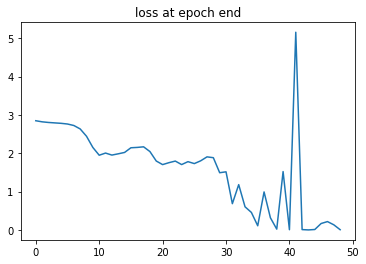

In [612]:
plt.plot(losses)
plt.title("loss at epoch end")
plt.show()

In [619]:
# Predict onto new names
for name in ["Hans", "Elliott", "Liam", "Kira", "Kisten", "Jerry", "Sasha", "Chester"]:
    p = model.predict(name)
    print(f"{name} - predicted origin: {p}")

Hans - predicted origin: Dutch
Elliott - predicted origin: English
Liam - predicted origin: Chinese
Kira - predicted origin: Portuguese
Kisten - predicted origin: Dutch
Jerry - predicted origin: French
Sasha - predicted origin: Japanese
Chester - predicted origin: French


# RNN at torch.nn level

In [781]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, activation):
        super(RNN, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.activation = activation

        self.i2h = nn.Linear(in_features = input_size + hidden_size, 
                            out_features = hidden_size)
        self.i2o = nn.Linear(in_features = input_size + hidden_size,
                            out_features = output_size)

        # reinitialize weights if recalling __init__
        self.apply(self._init_weights)
        # count params
        self.n_params = self._count_params()
        
    def forward(self, hidden, input, y=None):
        """Concatenate the inputs with the hidden state and forward pass through the linear layers (+ softmax)."""
        combined = torch.cat((input, hidden), dim=1)
        hidden_ = self.activation(self.i2h(combined))
        logits = self.i2o(combined)
        probs = torch.softmax(logits, dim=1)

        loss = None
        # if y is not None:
        #     y_ohe = torch.zeros(self.output_size)
        #     y_ohe[y] = 1.0
        #     loss = torch.nn.functional.cross_entropy(logits.squeeze(), y_ohe)

        return hidden_, logits, probs, loss

    def init_hidden(self):
        """initialization for the hidden state with the zero vector."""
        return torch.zeros(1, self.hidden_size)
    

    def _init_weights(self, module):
        """Reinitialize weights and biases."""
        if isinstance(module, nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight.data) ##since using tanh
            if module.bias is not None:
                module.bias.data.zero_()
    
    def _count_params(self):
        params = 0
        for p in self.parameters():
            params += p.nelement()
        return params


    # Create a train function (one training step)
    def train_step(self, category_tensor, line_tensor, lr):
        """Perform one forward and backward pass, and update model's weights."""
        
        # Initialize the hidden states (with zeros)
        hidden = self.init_hidden() 

        # Zero any gradients
        self.zero_grad()

        # FORWARD PASS
        for i in range(line_tensor.shape[0]):
            # FEED IN EACH CHARACTER OF THE LINE
            ## GET THE OUTPUT AND THE NEW HIDDEN STATE
            hidden, logits, probs, _ = self(hidden, line_tensor[i])
        
        # BACKWARD PASS
        # y_ohe = torch.zeros(len(all_categories))
        # y_ohe[category_tensor] = 1.0
        criterion = nn.CrossEntropyLoss()
        loss = criterion(logits, category_tensor) ##provide logits since this fn combines softmax w crossent
        loss.backward() #backprop

        # UPDATE
        for p in self.parameters():
            p.data += -lr * p.grad

        return logits, loss.item()

    # Just return an output given a line
    def evaluate(self, name : Union[str, torch.tensor], n_predictions : int=1):
        hidden = self.init_hidden()

        if type(name) == str:
            line_tensor = lineToTensor(name)
        elif type(name) == torch.Tensor:
            line_tensor = name
        else:
            print("Provide string or tensor")
            raise NotImplementedError

        with torch.no_grad():
            for t in range(line_tensor.shape[0]):
                hidden, logits, probs, loss = self(hidden, line_tensor[t])
        
        pred_cat = all_categories[torch.argmax(logits, dim=1)]
        topv, topi = logits.topk(n_predictions, 1, True)

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            # predictions.append([value, all_categories[category_index]])


        return pred_cat


In [782]:
# INITIALIZE MODEL (decided to use 2 RNN layers)
torch.manual_seed(12345)

n_hidden = 128
rnn = RNN(input_size=n_letters, 
          hidden_size=n_hidden, 
          output_size=n_categories, 
          activation=torch.tanh)


# Example
print("> Albert")
input = lineToTensor("Albert")

hidden = rnn.init_hidden()
next_hidden, logits, probs, _ = rnn(hidden, input[0])


print(logits.shape) ##1 x n_categories, where every category is the likelihood of that category.
print(categoryFromOutput(logits)) ## decoded prediction
print(categoryFromOutput(probs)) ## works if using softmaxed output too
print(f"\n Model params: {rnn.n_params}")


> Albert
torch.Size([1, 18])
('Russian', 14)
('Russian', 14)

 Model params: 27156


## training loop

In [784]:
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


lr = 0.01
n_iters = 10_000
print_every = 1000
plot_every = 10

current_loss = 0
all_losses = []

In [785]:
test_1_sample = False

start = time.time()
for iter in range(1, n_iters+1):
    cat_permutation = random.sample(all_categories, len(all_categories))
    for cat in cat_permutation: ##iterate through all possible categories and get one training ex for each
        # Get a batch (a random training example)
        category, line, category_tensor, line_tensor = randomTrainingExample(category=cat)
        
        if test_1_sample:
            category, line, line_tensor = "Italian", "Abandonato", lineToTensor("Abandonato")
            category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)

        # Perforam a train step and record loss
        logits, loss = rnn.train_step(category_tensor, line_tensor, lr=lr)
        current_loss += loss

    # print updates
    if (iter % print_every) == 0:
        guess, guess_i = categoryFromOutput(logits)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if (iter % plot_every) == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

1000 10% (0m 25s) 2.8804 Tourna / Spanish ✗ (Greek)
2000 20% (0m 51s) 2.9255 Loat / French ✗ (English)
3000 30% (1m 16s) 2.5910 Riedel / Spanish ✗ (Czech)
4000 40% (1m 41s) 0.5025 Minami / Japanese ✓
5000 50% (2m 7s) 1.5977 Roig / Chinese ✗ (Spanish)
6000 60% (2m 32s) 0.0199 Simoes / Portuguese ✓
7000 70% (2m 57s) 0.0283 Kido / Japanese ✓
8000 80% (3m 22s) 4.3577 Maas / Vietnamese ✗ (Dutch)
9000 90% (3m 47s) 1.4213 Dvorak / Portuguese ✗ (Czech)
10000 100% (4m 12s) 1.2490 Bruce / German ✗ (Scottish)


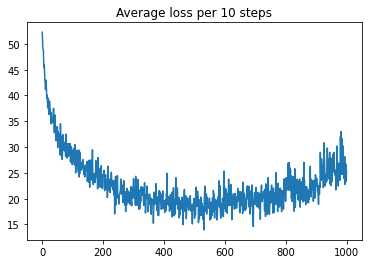

In [786]:
plt.plot(all_losses)
plt.title(f"Average loss per {plot_every} steps")
plt.show()

In [800]:
for name in ["MacGyver", "Blair", "Douglas", "Isla", "Fergus"]:
    print(name, "- prediction = ", rnn.evaluate(name))

MacGyver - prediction =  Scottish
Blair - prediction =  Scottish
Douglas - prediction =  Greek
Isla - prediction =  Arabic
Fergus - prediction =  Portuguese


# Confusion Matrix

C:\Users\hanse\AppData\Local\Temp\ipykernel_21744\1636018581.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
C:\Users\hanse\AppData\Local\Temp\ipykernel_21744\1636018581.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


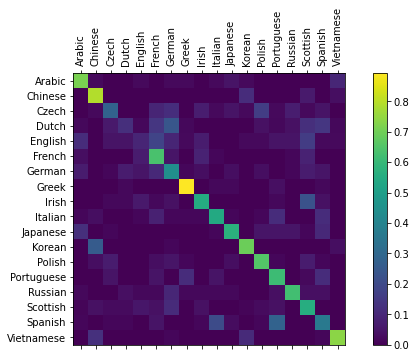

In [811]:
# Keep track of correct guesses in a confusion matrix (2x2 torch tensor)
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 1000

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    truth_cat, _, _, line_tensor = randomTrainingExample()
    guess_cat = rnn.evaluate(line_tensor)
    guess_ix = all_categories.index(guess_cat)
    truth_ix = all_categories.index(truth_cat)
    confusion[truth_ix][guess_ix] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()


# Set up plot
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# # Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

# User Input